In [198]:
# Library Import

# import jpype, jaydebeapi
import os, sys
import re
from pathlib import Path
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score


In [231]:
%matplotlib inline

# Option for jupyter
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.options.display.max_rows = 100
pd.options.display.max_columns = 999

In [3]:
# File Handling
def saveDataToCSV(file_path, data):
    data.to_csv(file_path, encoding = 'UTF-8', header = True, index = False)
    
def readFile(file_path):
#     file = open(file_path, 'r', encoding='UTF-8')
#     data = file.readlines().toString()
#     file.close()
    data = Path(file_path).read_text()
    return data

In [ ]:
#DB Connection
def startJVM():
    jar = os.getcwd()+'/lib/ojdbc6.jar'
    args = '-Djava.class.path=%s' % jar
    jvm_path = jpype.getDefaultJVMPath()
    jpype.startJVM(jvm_path, args)

def getDataFromDatabase(sql):
    query = None
    if(jpype.isJVMStarted()):
        print('JVM Already started')
    else:
        startJVM()
        
    query = readFile(sql)
    print(query)

    conn = jaydebeapi.connect('oracle.jdbc.driver.OracleDriver', 'jdbc:oracle:thin:CUI_APP/cui1234app@10.217.231.120:1524:TE2CUI1')
    curs = conn.cursor()
    curs.execute(query)
    data = pd.read_sql(query,conn)
    return data 

# Data Enrich Function

In [80]:
# 대기 중 공정 숫자 체크 -> 코드 추가 확인필요 
def get_waiting_function_number(row):
    temp_cnt = 0    
    for i in row['ORRE':'ORCN']:
            cnt0 = i.count('_0_')
            cnt3 = i.count('_3_')
            cnt5 = i.count('_5_')
            cnt6 = i.count('_6_')
            temp_cnt += cnt0
            temp_cnt += cnt3
            temp_cnt += cnt5
            temp_cnt += cnt6
    return temp_cnt

In [64]:
def correctDataRDD(row):
    if(int(row.OPN_HOPE_DATE[:4]) > 2100):
        return row.OPN_HOPE_DATE.replace(row.OPN_HOPE_DATE[:4], '2020')
    else:
        return row.OPN_HOPE_DATE

def correctDataRRDD(row):
    if(int(row.RMVL_HOPE_DATE[:4]) > 2100):
        return row.RMVL_HOPE_DATE.replace(row.RMVL_HOPE_DATE[:4], '2020')
    else:
        return row.RMVL_HOPE_DATE
        

In [158]:
def get_abnormal_pair_list(df):
    all_ordertype_list = df.ORDR_TYPE_ID.tolist()
    all_ordertype_set= set(all_ordertype_list)
    abnormal_pair = []

    for i in all_ordertype_set:
            temp_cnt = 0
            for j in all_ordertype_set:
                if(i in j):
                    if('D4' not in j):
                        temp_cnt += 1
            if(temp_cnt > 1):
#                 print(i, temp_cnt)
                abnormal_pair.append(i)
    return abnormal_pair

In [139]:
def calculate_sa_status(row):
    sa_status = row['SA']
    sa_list =sa_status.split('-')
    sa_result = list() 
    lbcs, lnod, lida, lmen = '','','',''
    
    for sa_status in sa_list:
        if('LBCS' in sa_status):
            lbcs = sa_status
        elif('LNOD' in sa_status):
            lnod = sa_status
        elif('LIDA' in sa_status):
            lida = sa_status
        elif('LMEN' in sa_status):
            lmen = sa_status

    if(len(lbcs) > 0):
        sa_result.append(lbcs)
    if(len(lnod) > 0):
        sa_result.append(lnod)
    if(len(lida) > 0):
        sa_result.append(lida)
    if(len(lmen) > 0):
        sa_result.append(lmen)
    if(len(sa_result) < 1):
        sa_result.append('NONE')
         
    return('-'.join(sa_result))    


In [140]:
def calculateLabel(row):
    resultSet = set()
    label = row['Label']
    
    for i in label:
        for j in i:
            resultSet.add(j)
    resultList = list(resultSet)
    
    if(len(resultList) < 1):
        resultList.append('NONE')
    
    return resultList

# 상수 설정

In [141]:
SYSDATE = datetime.today().strftime('%Y%m%d%H%M%S')
SQL_PATH = './sql/AI_Assistant_EDA_PNA_normal.sql'
DATA_PATH = './data'
FILE_NAME =  'AI_SIT_PNA_normal_v'+sysdate+'.csv'
MAX_DATE = '2099-12-31 23:59:59'

# 전역 변수

In [142]:
pna_function_list = ''

# File loading
- 데이터베이스에서 추출 한 *csv* file을 loading 한다 

In [143]:
FILE_NAME = 'AI_SIT_PNA_normal_v20200928134000.csv'
input_csv = pd.read_csv(DATA_PATH+'/'+FILE_NAME)

In [144]:
pna_df = input_csv.copy()
# get basic info
pna_df.describe()
pna_df.info()
pna_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10020 entries, 0 to 10019
Data columns (total 29 columns):
QUERY_DATE              10020 non-null object
CUST_ORDR_NO            10020 non-null object
CUST_ORDR_VER_NO        10020 non-null int64
ORDR_COMPOSI_IDFY_ID    10020 non-null object
LOB                     10020 non-null object
ORDR_TYPE_ID            10020 non-null object
CONUTC                  1891 non-null object
PROD_ID                 10019 non-null object
PROD_ORDR_SEQ           10020 non-null object
OBDNG_ID                10020 non-null object
FIRST_CRET_DT           10020 non-null object
LAST_CHG_DT             10020 non-null object
OPN_HOPE_DATE           5629 non-null object
RMVL_HOPE_DATE          4428 non-null object
ICIS_CMPLN_DATE         236 non-null object
LAST_PRCS_EXEC          9994 non-null object
ORRE                    10012 non-null object
PRDI                    9927 non-null object
LORD                    5889 non-null object
PHRD                    13

,QUERY_DATE,CUST_ORDR_NO,CUST_ORDR_VER_NO,ORDR_COMPOSI_IDFY_ID,LOB,ORDR_TYPE_ID,CONUTC,PROD_ID,PROD_ORDR_SEQ,OBDNG_ID,FIRST_CRET_DT,LAST_CHG_DT,OPN_HOPE_DATE,RMVL_HOPE_DATE,ICIS_CMPLN_DATE,LAST_PRCS_EXEC,ORRE,PRDI,LORD,PHRD,RECO,WODI,REAC,JUJO,SWBO,FUCO,MAUP,ORCN,SA
0,2020-09-28 13:41:45,11231G318317191,1,11231G318317191,SOIP,SB,NaN,0V02,10-10557349041,R00432,2020-09-09 14:04:01,2020-09-09 14:04:01,NaN,2011-08-19 16:00:00,NaN,2020-09-09 14:04:03,ORRE_2_OKEY,PRDI_0_OKEY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LIDA_ST-LIDA_CP-
1,2020-09-28 13:41:45,14120A001721891,2,14120A001721891-1065192,PSTN,BA,03,099S,10-11216267011-1065192,R02471,2014-05-06 07:36:28,2020-09-24 11:06:00,2014-06-27 12:00:00,NaN,NaN,2015-09-15 10:50:30,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,PHRD_2_OKEY,RECO_2_OKEY,WODI_2_OKEY,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-09-28 13:41:45,14129G007399991,5,14129G007399991-1065281,PSTN,B1,03,099S,10-11218253031-1065281,R02471,2014-05-09 16:04:43,2020-09-21 10:21:18,2015-10-26 00:00:00,NaN,NaN,2015-10-23 19:56:13,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NaN,RECO_2_OKEY,WODI_2_OKEY,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-09-28 13:41:45,14142A107439590,4,14142A1074395-18646433090,INTERNET,OA,59,099S,10-18646433090,R02471,2014-05-22 10:11:02,2020-09-14 17:58:31,2014-05-26 18:00:00,NaN,NaN,2015-01-22 19:39:00,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NaN,RECO_0_OKEY,WODI_2_OKEY,NaN,NaN,NaN,NaN,NaN,NaN,LIDA_ST-LIDA_CP-
4,2020-09-28 13:41:45,14163H208605591,1,14163H208605591-1065613,PSTN,B1,NaN,099S,10-11227430081-1065613,R02471,2014-06-12 17:19:46,2020-09-21 10:37:31,2014-06-14 18:00:00,NaN,NaN,2014-08-12 09:29:34,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,PHRD_2_OKEY,RECO_7_OKEY,WODI_2_OKEY,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 결측치 처리 - drop

In [145]:
# dropna
pna_df.dropna(subset=["PROD_ID"], inplace= True)
pna_df.dropna(subset=["LAST_PRCS_EXEC"], inplace= True)

# 결측치 처리 - fillna

In [146]:
# fill data
# date column
pna_df['OPN_HOPE_DATE'].fillna(pna_df['RMVL_HOPE_DATE'], inplace= True)
pna_df['RMVL_HOPE_DATE'].fillna(pna_df['OPN_HOPE_DATE'], inplace= True)
pna_df['ICIS_CMPLN_DATE'].fillna(MAX_DATE, inplace= True)


pna_func_column_list = pna_df.loc[:,'ORRE':'ORCN'].columns
for i in pna_func_column_list:
    pna_df[i].fillna('NONE_NONE_NONE', inplace = True)

pna_df['SA'].fillna('NONE', inplace = True)

# other value
pna_df['CONUTC'].fillna('BLANK', inplace = True)

# 형 변환

In [147]:
datetime_column_list = ['QUERY_DATE','FIRST_CRET_DT', 'LAST_CHG_DT',
       'OPN_HOPE_DATE', 'RMVL_HOPE_DATE', 'ICIS_CMPLN_DATE', 'LAST_PRCS_EXEC']

pna_df['OPN_HOPE_DATE'] = pna_df.apply(lambda row: correctDataRRDD(row), axis= 1)
pna_df['RMVL_HOPE_DATE'] = pna_df.apply(lambda row: correctDataRDD(row), axis= 1)

for column in datetime_column_list:
    pna_df[column] = pd.to_datetime(pna_df[column], format = '%Y-%m-%d %H:%M:%S')

# Data Enrich 

In [176]:
pna_df_enrich = pna_df[0:100].copy()

In [177]:
pna_df_enrich['WAITING_NUM'] = pna_df_enrich.apply(lambda row: get_waiting_function_number(row), axis=1)

In [178]:
pna_df_enrich['SA_FINAL'] = pna_df_enrich.apply(lambda row: calculate_sa_status(row), axis=1)

In [179]:
pna_df_enrich['sysDtLastChgDtDelta'] = (pna_df_enrich['QUERY_DATE'] - pna_df_enrich['LAST_CHG_DT']).astype('timedelta64[m]')
pna_df_enrich['sysDtLastExecDtDelta'] = (pna_df_enrich['QUERY_DATE'] - pna_df_enrich['LAST_PRCS_EXEC']).astype('timedelta64[m]')
pna_df_enrich['hopeDtSysDtDelta'] = (pna_df_enrich['OPN_HOPE_DATE'] - pna_df_enrich['QUERY_DATE']).astype('timedelta64[m]')

# 이상치 처리
- 쌍명령 중 1개만 검색 된 것 제외 (트레이닝 데이터 온리)

In [180]:
abnormal_pair_list = get_abnormal_pair_list(pna_df_enrich)
pna_df_enrich = pna_df_enrich[~pna_df_enrich['ORDR_TYPE_ID'].isin(abnormal_pair_list)]

In [267]:
pna_df_enrich.head()

,QUERY_DATE,CUST_ORDR_NO,CUST_ORDR_VER_NO,ORDR_COMPOSI_IDFY_ID,LOB,ORDR_TYPE_ID,CONUTC,PROD_ID,PROD_ORDR_SEQ,OBDNG_ID,FIRST_CRET_DT,LAST_CHG_DT,OPN_HOPE_DATE,RMVL_HOPE_DATE,ICIS_CMPLN_DATE,LAST_PRCS_EXEC,ORRE,PRDI,LORD,PHRD,RECO,WODI,REAC,JUJO,SWBO,FUCO,MAUP,ORCN,SA,WAITING_NUM,SA_FINAL,sysDtLastChgDtDelta,sysDtLastExecDtDelta,hopeDtSysDtDelta
0,2020-09-28 13:41:45,11231G318317191,1,11231G318317191,SOIP,SB,BLANK,0V02,10-10557349041,R00432,2020-09-09 14:04:01,2020-09-09 14:04:01,2011-08-19 16:00:00,2011-08-19 16:00:00,2099-12-31 23:59:59,2020-09-09 14:04:03,ORRE_2_OKEY,PRDI_0_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,LIDA_ST-LIDA_CP-,1,LIDA_CP,27337.0,27337.0,-4792182.0
1,2020-09-28 13:41:45,14120A001721891,2,14120A001721891-1065192,PSTN,BA,03,099S,10-11216267011-1065192,R02471,2014-05-06 07:36:28,2020-09-24 11:06:00,2014-06-27 12:00:00,2014-06-27 12:00:00,2099-12-31 23:59:59,2015-09-15 10:50:30,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,PHRD_2_OKEY,RECO_2_OKEY,WODI_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE,0,NONE,5915.0,2649771.0,-3290502.0
2,2020-09-28 13:41:45,14129G007399991,5,14129G007399991-1065281,PSTN,B1,03,099S,10-11218253031-1065281,R02471,2014-05-09 16:04:43,2020-09-21 10:21:18,2015-10-26 00:00:00,2015-10-26 00:00:00,2099-12-31 23:59:59,2015-10-23 19:56:13,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NONE_NONE_NONE,RECO_2_OKEY,WODI_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE,0,NONE,10280.0,2594505.0,-2591382.0
3,2020-09-28 13:41:45,14142A107439590,4,14142A1074395-18646433090,INTERNET,OA,59,099S,10-18646433090,R02471,2014-05-22 10:11:02,2020-09-14 17:58:31,2014-05-26 18:00:00,2014-05-26 18:00:00,2099-12-31 23:59:59,2015-01-22 19:39:00,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NONE_NONE_NONE,RECO_0_OKEY,WODI_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,LIDA_ST-LIDA_CP-,1,LIDA_CP,19903.0,2989082.0,-3336222.0
4,2020-09-28 13:41:45,14163H208605591,1,14163H208605591-1065613,PSTN,B1,BLANK,099S,10-11227430081-1065613,R02471,2014-06-12 17:19:46,2020-09-21 10:37:31,2014-06-14 18:00:00,2014-06-14 18:00:00,2099-12-31 23:59:59,2014-08-12 09:29:34,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,PHRD_2_OKEY,RECO_7_OKEY,WODI_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE,0,NONE,10264.0,3224412.0,-3308862.0


# Pre-processing - Label Encoding

### EDA Part



In [256]:
grouped_lob_df = pd.DataFrame(pna_df_enrich.groupby('LOB')['CUST_ORDR_NO'].count()).reset_index()
grouped_type_df = pd.DataFrame(pna_df_enrich.groupby('ORDR_TYPE_ID')['CUST_ORDR_NO'].count()).reset_index()

([<matplotlib.patches.Wedge at 0x7f9cf5d2f898>,
 [Text(-1.1326238229430847, 0.8228993107919048, 'INTERNET'),
  Text(-0.43686257005618306, -1.0095301356987352, 'IOT'),
  Text(0.9639374284254097, -0.52992889530635, 'IPTV'),
  Text(0.9287606220311785, 0.5894096257818147, 'PSTN'),
  Text(0.3068900307109565, 1.056323108262916, 'SOIP')],
 [Text(-0.7281153147491258, 0.5290066997947959, '30.00%'),
  Text(-0.2382886745760998, -0.5506528012902191, '27.00%'),
  Text(0.5257840518684053, -0.2890521247125545, '20.00%'),
  Text(0.5065967029260973, 0.3214961595173534, '14.00%'),
  Text(0.16739456220597623, 0.5761762408706814, '9.00%')])

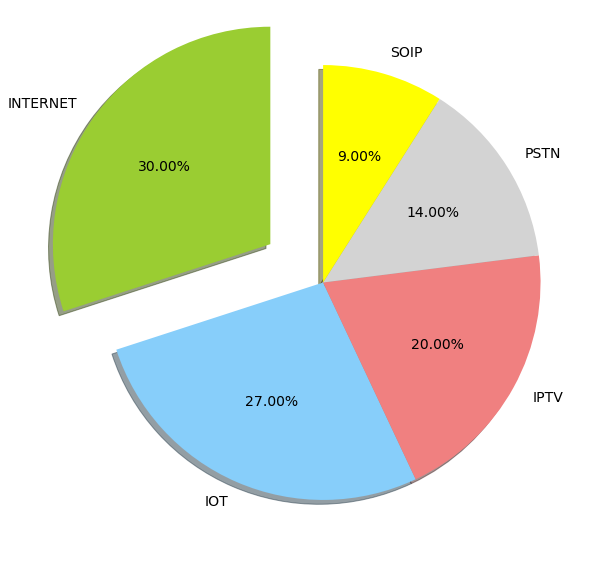

In [260]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.pie(grouped_lob_df.CUST_ORDR_NO,
        explode=(0.3,0,0,0,0), 
        labels=grouped_lob_df.LOB,
        colors=['yellowgreen', 'lightskyblue', 'lightcoral', 'lightgray', 'yellow'],
        autopct='%1.2f%%', # second decimal place
        shadow=True, 
        startangle=90,
        textprops={'fontsize': 14})

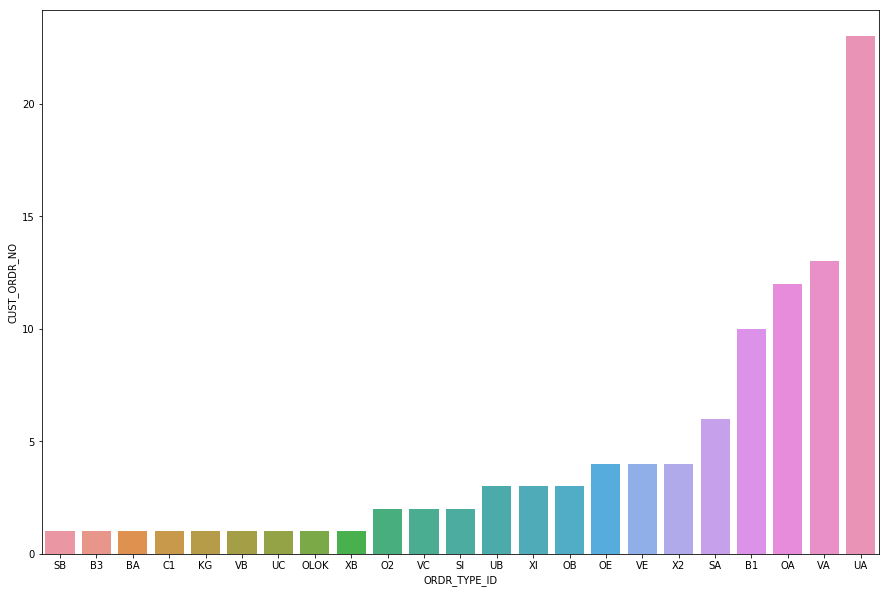

In [264]:
sns.barplot(data=grouped_type_df.sort_values(by='CUST_ORDR_NO'), x='ORDR_TYPE_ID', y='CUST_ORDR_NO')

In [270]:
test_df = pna_df_enrich[:100].copy()
test_df['Label'] = ''
test_df['Label'] = test_df['Label'].apply(list)
test_df

,QUERY_DATE,CUST_ORDR_NO,CUST_ORDR_VER_NO,ORDR_COMPOSI_IDFY_ID,LOB,ORDR_TYPE_ID,CONUTC,PROD_ID,PROD_ORDR_SEQ,OBDNG_ID,FIRST_CRET_DT,LAST_CHG_DT,OPN_HOPE_DATE,RMVL_HOPE_DATE,ICIS_CMPLN_DATE,LAST_PRCS_EXEC,ORRE,PRDI,LORD,PHRD,RECO,WODI,REAC,JUJO,SWBO,FUCO,MAUP,ORCN,SA,WAITING_NUM,SA_FINAL,sysDtLastChgDtDelta,sysDtLastExecDtDelta,hopeDtSysDtDelta,Label
0,2020-09-28 13:41:45,11231G318317191,1,11231G318317191,SOIP,SB,BLANK,0V02,10-10557349041,R00432,2020-09-09 14:04:01,2020-09-09 14:04:01,2011-08-19 16:00:00,2011-08-19 16:00:00,2099-12-31 23:59:59,2020-09-09 14:04:03,ORRE_2_OKEY,PRDI_0_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,LIDA_ST-LIDA_CP-,1,LIDA_CP,27337.0,27337.0,-4792182.0,[]
1,2020-09-28 13:41:45,14120A001721891,2,14120A001721891-1065192,PSTN,BA,03,099S,10-11216267011-1065192,R02471,2014-05-06 07:36:28,2020-09-24 11:06:00,2014-06-27 12:00:00,2014-06-27 12:00:00,2099-12-31 23:59:59,2015-09-15 10:50:30,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,PHRD_2_OKEY,RECO_2_OKEY,WODI_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE,0,NONE,5915.0,2649771.0,-3290502.0,[]
2,2020-09-28 13:41:45,14129G007399991,5,14129G007399991-1065281,PSTN,B1,03,099S,10-11218253031-1065281,R02471,2014-05-09 16:04:43,2020-09-21 10:21:18,2015-10-26 00:00:00,2015-10-26 00:00:00,2099-12-31 23:59:59,2015-10-23 19:56:13,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NONE_NONE_NONE,RECO_2_OKEY,WODI_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE,0,NONE,10280.0,2594505.0,-2591382.0,[]
3,2020-09-28 13:41:45,14142A107439590,4,14142A1074395-18646433090,INTERNET,OA,59,099S,10-18646433090,R02471,2014-05-22 10:11:02,2020-09-14 17:58:31,2014-05-26 18:00:00,2014-05-26 18:00:00,2099-12-31 23:59:59,2015-01-22 19:39:00,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NONE_NONE_NONE,RECO_0_OKEY,WODI_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,LIDA_ST-LIDA_CP-,1,LIDA_CP,19903.0,2989082.0,-3336222.0,[]
4,2020-09-28 13:41:45,14163H208605591,1,14163H208605591-1065613,PSTN,B1,BLANK,099S,10-11227430081-1065613,R02471,2014-06-12 17:19:46,2020-09-21 10:37:31,2014-06-14 18:00:00,2014-06-14 18:00:00,2099-12-31 23:59:59,2014-08-12 09:29:34,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,PHRD_2_OKEY,RECO_7_OKEY,WODI_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE,0,NONE,10264.0,3224412.0,-3308862.0,[]
5,2020-09-28 13:41:45,14177A408541091,1,14177A408541091-1055586,PSTN,B1,BLANK,099S,10-11188064451-1055586,R02471,2014-06-26 10:41:19,2020-09-21 10:45:32,2014-06-27 12:00:00,2014-06-27 12:00:00,2099-12-31 23:59:59,2016-01-07 13:35:18,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,PHRD_2_OKEY,RECO_7_OKEY,WODI_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE,0,NONE,10256.0,2485446.0,-3290502.0,[]
6,2020-09-28 13:41:45,14177A408541391,1,14177A408541391-1055589,PSTN,B1,BLANK,099S,10-11188064481-1055589,R02471,2014-06-26 10:41:21,2020-09-21 10:45:59,2014-06-27 12:00:00,2014-06-27 12:00:00,2099-12-31 23:59:59,2014-06-26 10:42:50,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,PHRD_2_OKEY,RECO_7_OKEY,WODI_7_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE,0,NONE,10255.0,3292018.0,-3290502.0,[]
7,2020-09-28 13:41:45,14267G557145990,4,14267G5571459-10715999960,INTERNET,XB,BLANK,099S,10-10715999960,R00436,2014-09-24 16:55:39,2020-09-16 09:57:18,2014-09-24 18:00:00,2014-09-24 18:00:00,2099-12-31 23:59:59,2015-04-23 14:56:07,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,PHRD_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,REAC_6_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,LIDA_ST-,1,LIDA_ST,17504.0,2858325.0,-3161982.0,[]
8,2020-09-28 13:41:45,1430394046669A0,12,1430394046669-12017256550,INTERNET,OLOK,06525974,0822,20-12017256550,

### Labeling

In [ ]:
# ORCN
label_pna_normal_NC00 =  test_df.loc[((test_df['ORDR_TYPE_ID'].str.len() > 3) & 
                                                     (
                                                      (test_df['ORCN'] == 'ORCN_2_OKEY-ORCN_2_OKEY') | ((test_df[('ORCN','')] == 'ORCN_2_OKEY') & (test_df[('WAITING_NUM','min')] > 0))
                                                     )
                                                   | ((test_df[('ORDR_TYPE_ID','max')].str.len() < 3) & (test_df[('ORCN','')].isin(['ORCN_2_OKEY', 'ORCN_7_OKEY']))))]

test_df[test_df.index.isin(test_df.index)].Label.apply(lambda x: x.append('NC00') or x) 
